# Import Packages

In [54]:
import os
import sys
import gzip

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import time
import requests

from ast import literal_eval
from itertools import product

from scipy.sparse import coo_matrix, csr_matrix, diags
from scipy.sparse.linalg import svds, norm as spnorm

from numpy.linalg import qr, svd

from tqdm import tqdm
from evaluation import model_evaluate, simple_model_recom_func, downvote_seen_items

import warnings
warnings.filterwarnings('ignore')

np.random.seed(2022)

# Download Data

In [31]:
def amazon_data_reader(path):
    with gzip.open(path, 'rt') as gz:
        for line in gz:
            yield literal_eval(line)

In [32]:
def get_amazon_data(json_filename = 'reviews_Electronics_5.json.gz',
                    url_json = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz'):
    
    if json_filename in os.listdir():
        pass
    else:
        r = requests.get(url_json)
        with open(json_filename , 'wb') as f:
            f.write(r.content)

    col_names_mapping = dict(zip(
        ['reviewerID', 'asin', 'overall', 'unixReviewTime'],
        ['userid', 'itemid', 'rating', 'timestamp']
    ))

    pure_data = pd.DataFrame.from_records(
        amazon_data_reader(json_filename),
        columns=['reviewerID', 'asin', 'overall', 'unixReviewTime']
    ).rename(columns=col_names_mapping)

    return pure_data

In [23]:
%%time
pure_data = get_amazon_data()    

CPU times: user 1min 57s, sys: 4.84 s, total: 2min 2s
Wall time: 2min 2s


In [24]:
pure_data.shape

(1689188, 4)

# Prepare Data

In [55]:
def get_random_user_subset(data, size, unique_users=None):
    
    if unique_users is None:
        unique_users = data['userid'].unique()
        
    user_subset = np.random.choice(unique_users, size=size)
    data = data[data['userid'].isin(user_subset)]
    
    return data

def get_chronological_sorted_data(data):
    # change user and item ids to be indexed in chronological order
    user_ids = data.sort_values('timestamp')['userid'].unique()
    user_map = dict(zip(user_ids, range(len(user_ids))))
    data['userid'] = data['userid'].map(user_map)

    item_ids = data.sort_values('timestamp')['itemid'].unique()
    item_map = dict(zip(item_ids, range(len(item_ids))))
    data['itemid'] = data['itemid'].map(item_map)
    
    return data

In [56]:
# prepare data subset in order to make computations faster
data = get_random_user_subset(pure_data, size=20000)
data = get_chronological_sorted_data(data)

print(data.shape)

(166436, 4)


In [36]:
data.head()

,userid,itemid,rating,timestamp
9,167,39505,5.0,1390176000
24,14296,3976,4.0,1389052800
65,14050,3976,4.0,1384300800
80,10335,3976,5.0,1335916800
83,18606,3976,5.0,1395446400


### split into base and future

In [58]:
def base_future_split(data, base_size=0.5):

    ts_base = data['timestamp'].quantile(base_size)

    data_base = (
        data
        .query(f"timestamp <= @ts_base")
        .sort_values('timestamp')
    )
    
    data_future = (
        data
        .query(f"timestamp > @ts_base")
        .sort_values('timestamp')
    )
    
    return data_base, data_future

In [59]:
data_base, data_future = base_future_split(data, base_size=0.5)

In [60]:
len(data_base), len(data_future)

(83324, 83112)

# Prepare Functions

### transform dataframe into matrix

In [61]:
def to_matrix(data, description):
    user_ids, item_ids = data[description['users']], data[description['items']]
    
    ratings = data[description['feedback']]
    shape = (description['n_users'], description['n_items'])
    
    return csr_matrix((ratings, (user_ids, item_ids)), shape)

### construct basic SVD model

In [62]:
def get_svd_model(matrix, rank):
    u, s, vt = svds(matrix, k=rank)
    
    U = np.ascontiguousarray(u[:, ::-1])
    V = np.ascontiguousarray(vt[::-1, :].T)
    s = s[::-1]
    
    params = U, s, V
    return params

### update SVD factors using new interactions

In [63]:
def update_svd_model_using_interactions(params_base, A_new, verbose=False):
    U_base, s_base, V_base = params_base
    S_base = np.diag(s_base)
    
    # m is number of users and n is number of items
    
    temp = A_new @ V_base # m x r
    rank = len(s_base)
    
    # 1st step
    K = U_base @ S_base + temp # m x r
    if verbose: print('1st step done!')
    
    # 2nd step
    U_updated, _ = qr(K) # m x r, r x r
    if verbose: print('2nd step done!')
    
    # 3rd step
    _ = _ - U_updated.T @ temp # r x r
    if verbose: print('3rd step done!')
    
    # 4th step
    L = V_base @ _.T + A_new.T @ U_updated # n x r
    if verbose: print('4th step done!')
    
    # 5th step
    V_updated, S_updated = qr(L) # n x r, r x r
    if verbose: print('5th step done!')
    
    params_updated = U_updated, np.diag(S_updated), V_updated
    return params_updated

### update SVD factors using new users and items

In [64]:
def svd_col_expansion(U, s, Vt, C):
    rank = len(s)
    C = C[:U.shape[0]]

    L = U.T @ C
    H = C - U @ L
    J, K = qr(H)
    
    volume = np.sqrt(np.linalg.det(K.T @ K))

    Q = np.block([
        [np.diag(s),                     L],
        [np.zeros((K.shape[0], len(s))), K]
    ])
    
    U_q, s_q, Vt_q = svd(Q, full_matrices=True)

    U_new = np.hstack((U, J)) @ U_q
    s_new = s_q
    
    Vt_new = Vt_q @ np.block([
        [Vt,                                  np.zeros((Vt.shape[0], C.shape[1]))],
        [np.zeros((C.shape[1], Vt.shape[1])), np.eye(C.shape[1])]
    ])

    return U_new[:,:rank], s_new[:rank], Vt_new[:rank,:]

In [65]:
def update_svd_model_using_users_and_items(params_base, R, C):
    
    if C.shape[1] > 0:
        U_base, s_base, V_base = params_base
        _, s_new, Vt_new = svd_col_expansion(U_base, s_base, V_base.T, C)
        V_new = Vt_new.T
    
    if R.shape[0] > 0:
        U_base, s_base, V_base = params_base
        _, s_new, Ut_new = svd_col_expansion(V_base, s_new, U_base.T, R.T)
        U_new = Ut_new.T
    
    return U_new, s_new, V_new

### score using SVD

In [66]:
def score_svd_model(params, matrix):
    _, _, V = params
    scores = matrix @ V @ V.T
    
    return scores

### prepare future and holdout

In [67]:
def get_holdout_subset(data_base, data_future):
    # get first interaction for each user in validation set
    data_holdout = data_future.drop_duplicates(subset='userid', keep='first')
    
    # remove completely new users or items
    user_ids = data_base['userid'].unique()
    data_holdout = data_holdout.query("userid in @user_ids")
    
    item_ids = data_base['itemid'].unique()
    data_holdout = data_holdout.query("itemid in @item_ids")
    
    if data_holdout.shape[0] == 0:
        warnings.warn("WARNING: holdout has no valid user for predicting")
        
    return data_holdout

In [68]:
def get_future_subsets(data_future, n_steps=20):
    ts_min, ts_max = data_future['timestamp'].min(), data_future['timestamp'].max() + 1
    checkpoints = np.linspace(ts_min, ts_max, n_steps + 1)
    
    splits = []
    start_times = checkpoints[:-1]
    stop_times = np.roll(checkpoints, -1)[:-1]
    
    for start, stop in zip(start_times, stop_times):
        split = data_future.query(f"timestamp >= @start and timestamp < @stop")
        
        if split.shape[0] == 0:
            warnings.warn("WARNING: validation split time period has no observation")
        
        splits.append(split)
    
    return splits, start_times, stop_times

### some utils

In [69]:
def get_updated_base(data_base, data_future):
    return pd.concat([data_base, data_future])

In [70]:
def count_new_users_and_items(data_base_current, data_future_current):
    user_ids_base, item_ids_base = data_base_current['userid'].unique(), data_base_current['itemid'].unique()
    
    n_new_users = data_future_current[
        ~data_future_current['userid'].isin(user_ids_base)
    ]['userid'].nunique()
    
    n_new_items = data_future_current[
        ~data_future_current['itemid'].isin(item_ids_base)
    ]['itemid'].nunique()
    
    return n_new_users, n_new_items

# Conduct Experiments

In [71]:
rank = 256
n_top = 20
n_steps = 20

### perform experiments with direct recomputation of SVD

In [72]:
description = {
    'users': 'userid',
    'items': 'itemid',
    'feedback': 'rating',
    
    'n_users': data_base['userid'].nunique(),
    'n_items': data_base['itemid'].nunique(),
}

In [73]:
data_base_current = data_base.copy()
matrix_base_current = to_matrix(data_base_current, description)

In [74]:
%%time
params_current = get_svd_model(matrix_base_current, rank)

CPU times: user 34 s, sys: 2.16 s, total: 36.2 s
Wall time: 19.1 s


In [75]:
basic_performance_history = []
basic_time_history = []

verbose = False

splits, start_times, stop_times = get_future_subsets(data_future, n_steps)

for split in tqdm(splits):
    
    ## ------------------------------------------- prepare data -------------------------------------------
    
    # get current valid
    data_future_current = split
    
    # extract holdout from valid
    data_holdout = get_holdout_subset(data_base_current, data_future_current)
    
    # prepare matrix for holdout users
    user_ids_holdout = data_holdout['userid'].values
    matrix_observed = matrix_base_current[user_ids_holdout]
    
    # prepare observed in order to downvote after scoring
    data_observed = data_base_current.query('userid in @user_ids_holdout')
    
    # prepare holdout and observed for evaluating — reindex users
    reindex_map = dict(zip(user_ids_holdout, np.arange(len(user_ids_holdout))))
    
    for _ in [data_holdout, data_observed]:
        _.loc[:, 'userid'] = _['userid'].map(reindex_map)
        
    ## ---------------------------------- perform scoring and evaluation ----------------------------------

    # score holdout users
    scores = score_svd_model(params_current, matrix_observed)
    if verbose: print('scoring done!')
    
    # downvote items which occured on train
    downvote_seen_items(scores, data_observed, description)
    
    # construct predictions
    predictions = simple_model_recom_func(scores, topn=n_top)
    if verbose: print('predictions done!')

    # evaluate metrics on holdout scores
    metrics = model_evaluate(predictions, data_holdout, description, topn=n_top)
    basic_performance_history.append(metrics)
    if verbose: print('metrics done!')
        
    ## -------------------------------------- update model parameters -------------------------------------
    
    # update train as data
    data_base_current = get_updated_base(data_base_current, data_future_current)
    
    description['n_users'] = data_base_current['userid'].nunique()
    description['n_items'] = data_base_current['itemid'].nunique()
    
    # recompute SVD factors of train data
    start = time.time()
    matrix_base_current = to_matrix(data_base_current, description)
    params_current = get_svd_model(matrix_base_current, rank)
    end = time.time()
    
    basic_time_history.append(end - start)
    if verbose: print('update done!')

basic_performance_history = np.array(basic_performance_history)
basic_time_history = np.array(basic_time_history)

100%|██████████| 20/20 [09:34<00:00, 28.73s/it]


### perform experiments with dynamic update of SVD

In [76]:
description = {
    'users': 'userid',
    'items': 'itemid',
    'feedback': 'rating',
    
    'n_users': data_base['userid'].nunique(),
    'n_items': data_base['itemid'].nunique(),
}

In [77]:
data_base_current = data_base.copy()
matrix_base_current = to_matrix(data_base_current, description)

In [78]:
%%time
params_current = get_svd_model(matrix_base_current, rank)

CPU times: user 34.5 s, sys: 2.19 s, total: 36.7 s
Wall time: 19.2 s


In [79]:
dynamic_performance_history = []
dynamic_time_history = []

verbose = False

# splits, start_times, stop_times = get_future_subsets(data_future, n_steps)

for split in tqdm(splits):
    
    ## ------------------------------------------- prepare data -------------------------------------------
    
    # get current valid
    data_future_current = split
    
    # extract holdout from valid
    data_holdout = get_holdout_subset(data_base_current, data_future_current)
    
    # prepare matrix for holdout users
    user_ids_holdout = data_holdout['userid'].values
    matrix_observed = matrix_base_current[user_ids_holdout]
    
    # prepare observed in order to downvote after scoring
    data_observed = data_base_current.query('userid in @user_ids_holdout')
    
    # prepare holdout and observed for evaluating — reindex users
    reindex_map = dict(zip(user_ids_holdout, np.arange(len(user_ids_holdout))))
    
    for _ in [data_holdout, data_observed]:
        _.loc[:, 'userid'] = _['userid'].map(reindex_map)
        
    ## ---------------------------------- perform scoring and evaluation ----------------------------------

    # score holdout users
    scores = score_svd_model(params_current, matrix_observed)
    if verbose: print('scoring done!')
    
    # downvote items which occured on train
    downvote_seen_items(scores, data_observed, description)
    
    # construct predictions
    predictions = simple_model_recom_func(scores, topn=n_top)
    if verbose: print('predictions done!')

    # evaluate metrics on holdout scores
    metrics = model_evaluate(predictions, data_holdout, description, topn=n_top)
    dynamic_performance_history.append(metrics)
    if verbose: print('metrics done!')
        
    ## -------------------------------------- update model parameters -------------------------------------
        
    # count number of new users and items
    n_new_users, n_new_items = count_new_users_and_items(data_base_current, data_future_current)
    
    # update SVD factors using new interactions
    start = time.time()
    data_new = data_future_current[
        data_future_current['userid'].isin(data_base_current['userid'].unique()) & 
        data_future_current['itemid'].isin(data_base_current['itemid'].unique())
    ]
    matrix_new = to_matrix(data_new, description)
    params_current = update_svd_model_using_interactions(params_current, matrix_new)
    end = time.time()
    
    dynamic_time_history.append(end - start)
    
    # update train as data
    data_base_current = get_updated_base(data_base_current, data_future_current)

    description['n_users'] = data_base_current['userid'].nunique()
    description['n_items'] = data_base_current['itemid'].nunique()
    
    # update SVD factors using new users and items
    start = time.time()
    matrix_base_current = to_matrix(data_base_current, description)
    
    rows_new, columns_new = matrix_base_current[-n_new_users:, :], matrix_base_current[:, -n_new_items:]
    params_current = update_svd_model_using_users_and_items(params_current, rows_new, columns_new)
    end = time.time()
    
    dynamic_time_history[-1] += end - start
    if verbose: print('update done!')

dynamic_performance_history = np.array(dynamic_performance_history)
dynamic_time_history = np.array(dynamic_time_history)

100%|██████████| 20/20 [04:00<00:00, 12.03s/it]


# Compare Results

In [81]:
def plot_metric(metric_name,
                stop_times,
                basic_value_history,
                dynamic_value_history,
                n_top=20):
  
    plt.figure(figsize=(12, 6))

    plt.plot(stop_times, basic_value_history, label='basic', marker='o')
    plt.plot(stop_times, dynamic_value_history, label='dynamic', marker='o')

    plt.title(metric_name + '@{}'.format(n_top), fontsize=14)
    plt.legend(fontsize=12)

    plt.xticks(stop_times[::2])
    plt.xlabel('timestamp', fontsize=12)

    plt.grid()
    plt.show()

### HR

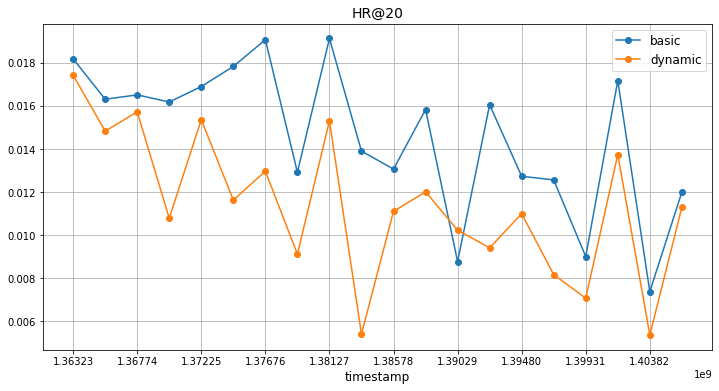

In [87]:
plot_metric('HR',
            stop_times,
            basic_performance_history[:, 0],
            dynamic_performance_history[:, 0],
            n_top=20)

### MRR

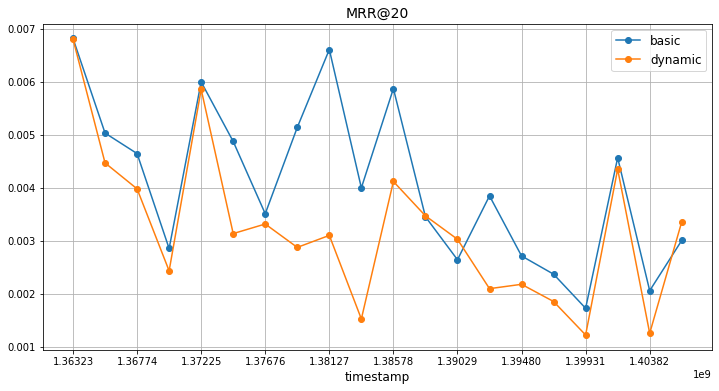

In [88]:
plot_metric('MRR',
            stop_times,
            basic_performance_history[:, 1],
            dynamic_performance_history[:, 1],
            n_top=20)

### coverage

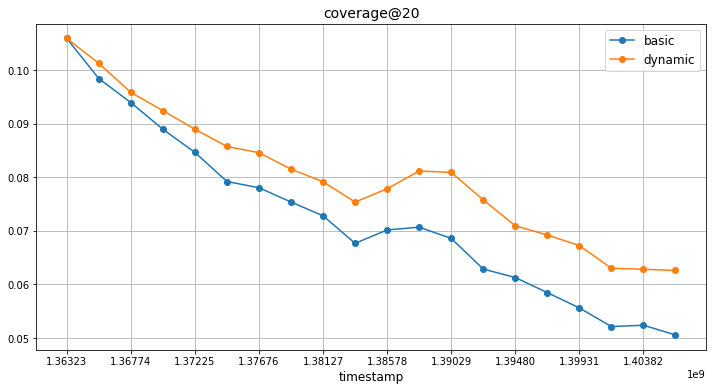

In [89]:
plot_metric('coverage',
            stop_times,
            basic_performance_history[:, 2],
            dynamic_performance_history[:, 2],
            n_top=20)

### computation time

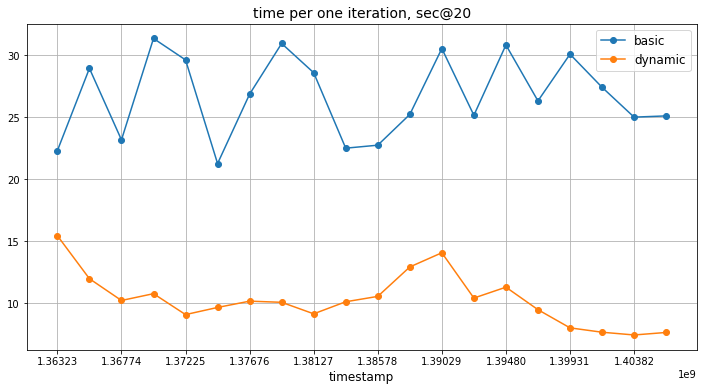

In [91]:
plot_metric('time per one iteration, sec',
            stop_times,
            basic_time_history,
            dynamic_time_history,
            n_top=20)